In [132]:
from astropy.table import Table
from gala.coordinates import reflex_correct
import pandas as pd
from sklearn.neighbors import KDTree as kdtree
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import astropy.coordinates as coord
import astropy.units as u
import gala.coordinates as gc

In [2]:
data = Table.read('RRLyrae_PS1_GDR2.fits')

In [3]:
data.keys()

['dist',
 'rrlyrae_ps1_sesar_etal_oid',
 'ra_1',
 'dec_1',
 'solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra_1a',
 'ra_error',
 'dec_1a',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_ty

"""
       (data['ebv'] < 5) & (bprp < 1) & (Ag < 5) & \
       (np.abs(cGal.z) > 1*u.kpc) & \
       (np.abs(cSag.Beta) > 10.*u.deg) & \
       (np.sqrt((cGalactic.l - 280.4652*u.deg)**2. + (cGalactic.b - -32.8884*u.deg)**2) > 15*u.deg) & \
       (np.sqrt((cGalactic.l - 302.8084*u.deg)**2  + (cGalactic.b - -44.3277*u.deg)**2) > 10*u.deg) & 
"""

In [4]:
threshold = 0.8
sn_threshold = 1
#forsure = ~np.isnan(data['pmra']) & \
#       ~np.isnan(data['pmdec']) & \
#       (data['RRab'] > threshold) & \
#       (np.abs(data['pmra'])/data['pmra_error'] >= sn_threshold) & \
#       (np.abs(data['pmdec'])/data['pmdec_error'] >= sn_threshold)

forsure = ~np.isnan(data['pmra']) & \
       ~np.isnan(data['pmdec']) & \
       (data['RRab'] > threshold) & \
       (data['pmra_error'] < 1) & \
       (data['pmdec_error']< 1)

/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


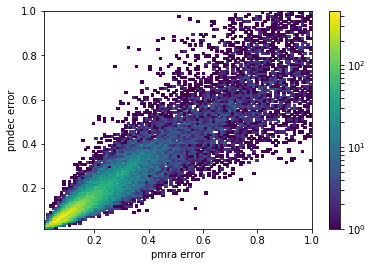

In [5]:
H, xe, ye = np.histogram2d(data['pmra_error'][forsure], data['pmdec_error'][forsure], bins=100)
plt.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm())
plt.xlabel('pmra error')
plt.ylabel('pmdec error')
plt.colorbar()

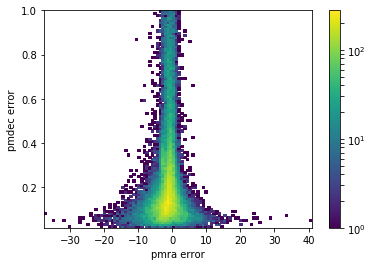

In [6]:
H, xe, ye = np.histogram2d(data['pmra'][forsure], data['pmra_error'][forsure], bins=100)
plt.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm())
plt.xlabel('pmra error')
plt.ylabel('pmdec error')
plt.colorbar()

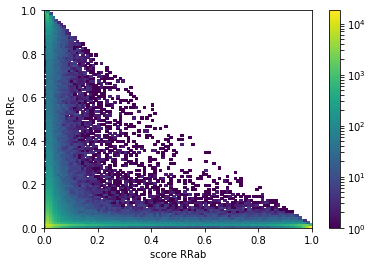

In [7]:
H, xe, ye = np.histogram2d(data['RRab'], data['RRc'], bins=100)
plt.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm())
plt.xlabel('score RRab')
plt.ylabel('score RRc')
plt.colorbar()

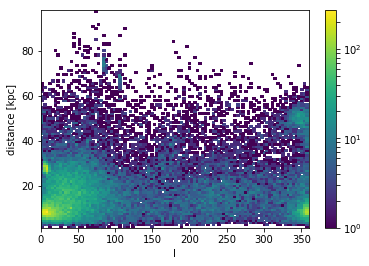

In [8]:
distance = 10.**(0.2*data['DM'] + 1)/1000
H, xe, ye = np.histogram2d(data['l'][forsure], distance[forsure], bins=100)
plt.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm())
plt.xlabel('l')
plt.ylabel('distance [kpc]')
plt.colorbar()

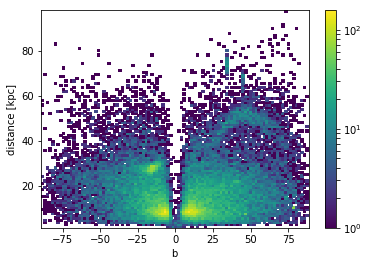

In [9]:
H, xe, ye = np.histogram2d(data['b'][forsure], distance[forsure], bins=100)
plt.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm())
plt.xlabel('b')
plt.ylabel('distance [kpc]')
plt.colorbar()

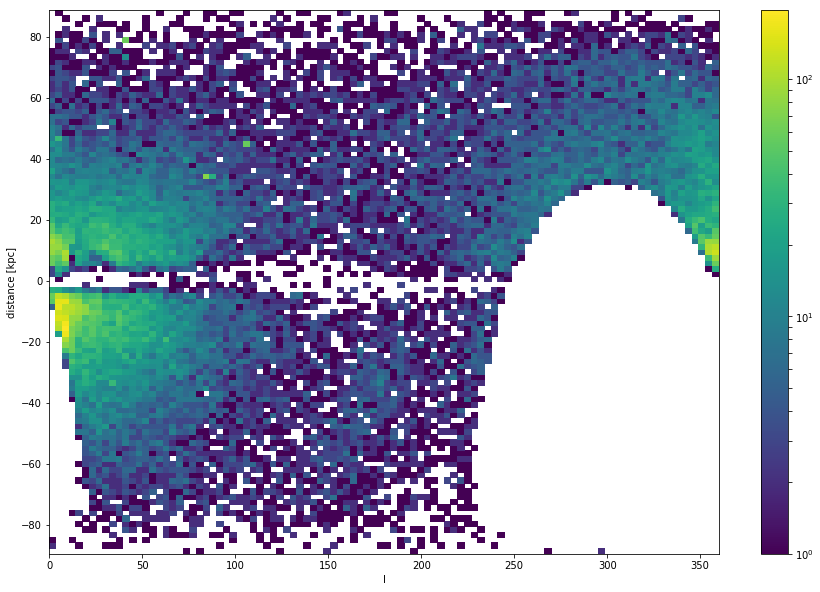

In [10]:
plt.figure(figsize=(15, 10))
H, xe, ye = np.histogram2d(data['l'][forsure], data['b'][forsure], bins=100)
plt.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm())
plt.xlabel('l')
plt.ylabel('distance [kpc]')
plt.colorbar()

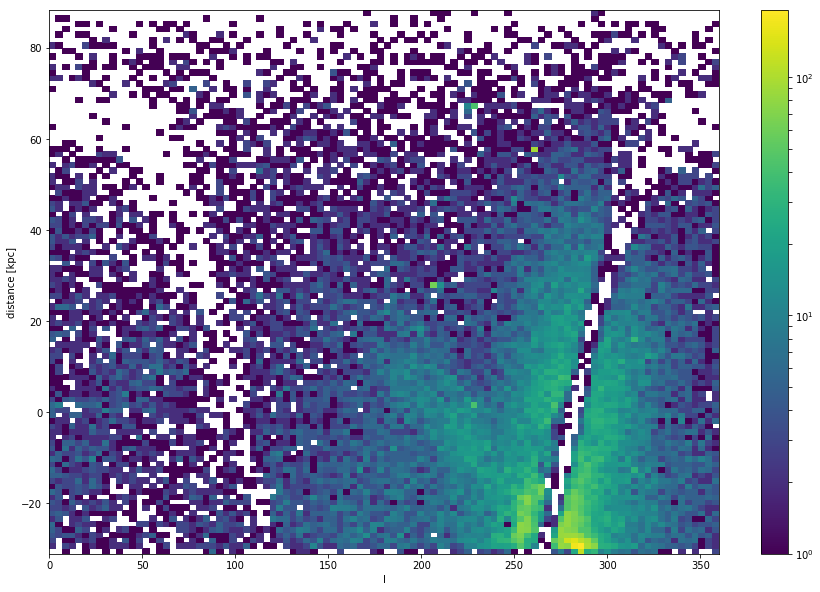

In [11]:
plt.figure(figsize=(15, 10))
H, xe, ye = np.histogram2d(data['ra_1a'][forsure], data['dec_1a'][forsure], bins=100)
plt.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm())
plt.xlabel('l')
plt.ylabel('distance [kpc]')
plt.colorbar()

Text(0.5,0,'dust')

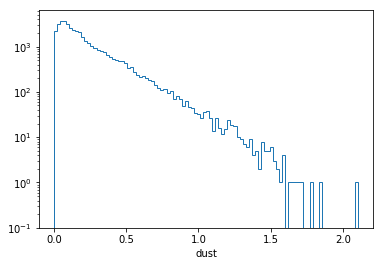

In [12]:
plt.hist(data['EB-V'][forsure], bins=100, histtype='step', log=True)
plt.xlabel('dust')

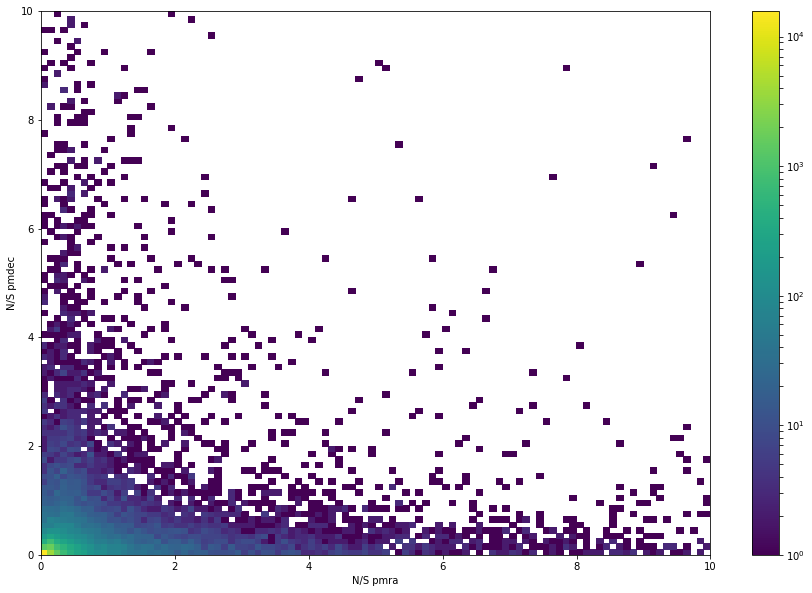

In [13]:
plt.figure(figsize=(15, 10))
H, xe, ye = np.histogram2d(data['pmra_error'][forsure]/np.abs(data['pmra'][forsure]), 
                           data['pmdec_error'][forsure]/np.abs(data['pmdec'][forsure]), 
                           bins=100, range= [[0,10],[0,10]])
plt.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm())
plt.xlabel('N/S pmra')
plt.ylabel('N/S pmdec')
plt.colorbar()

In [14]:
c = coord.SkyCoord(ra=data['ra_1a'][forsure], 
                   dec=data['dec_1a'][forsure], 
                   pm_ra_cosdec=data['pmra'][forsure],
                   pm_dec=data['pmdec'][forsure],
                   distance = distance[forsure]*u.kpc, 
                   radial_velocity=0.*u.km/u.s)
cCorrect = reflex_correct(c)
cGal = cCorrect.transform_to(coord.Galactic)
cGalactic = cCorrect.transform_to(coord.Galactic)
cGal.set_representation_cls('cartesian')

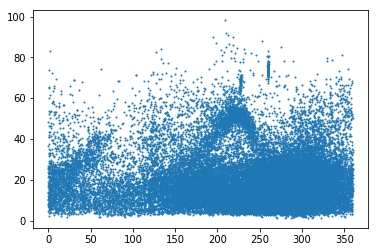

In [15]:
plt.scatter(c.ra, c.distance, s=1)

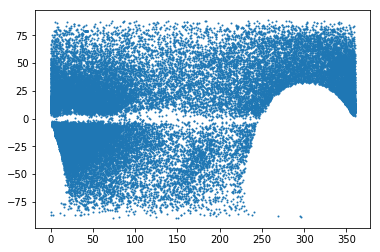

In [16]:
plt.scatter(cGalactic.l, cGalactic.b, s=1)

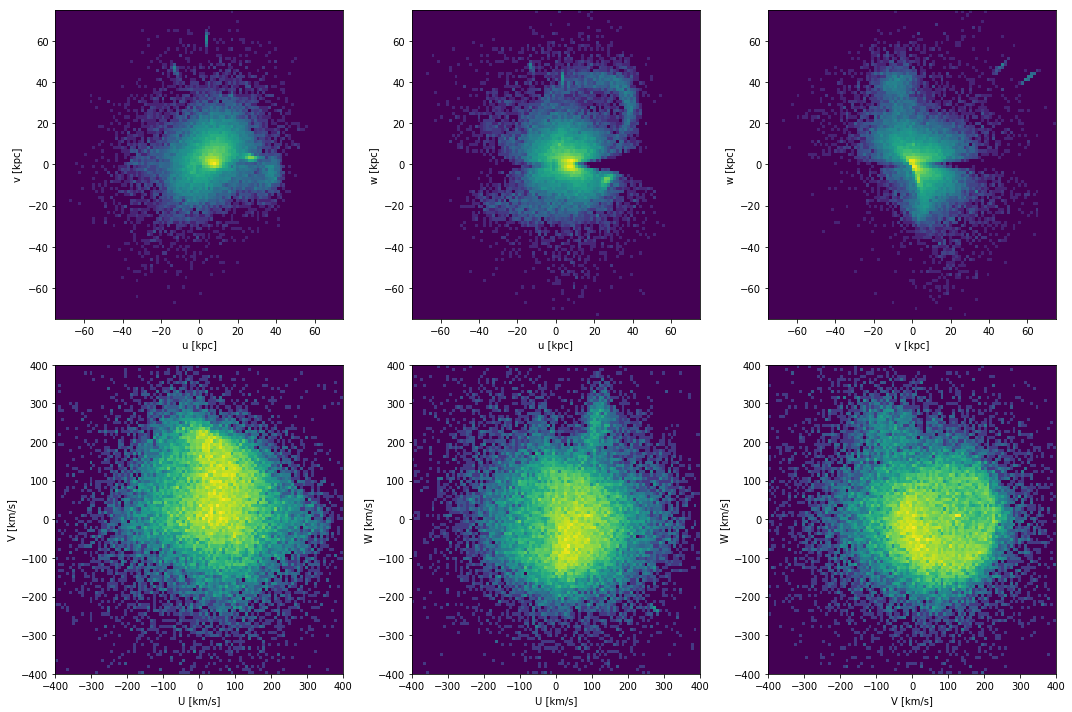

In [17]:
x = [cGal.u, cGal.u, cGal.v, cGal.U, cGal.U, cGal.V]
y = [cGal.v, cGal.w, cGal.w, cGal.V, cGal.W, cGal.W]
limPos = [-75, 75]
limVel = [-400, 400]
ranges = [limPos, limPos, limPos, limVel, limVel, limVel]
xlabel = ['u [kpc]', 'u [kpc]', 'v [kpc]', 'U [km/s]', 'U [km/s]', 'V [km/s]']
ylabel = ['v [kpc]', 'w [kpc]', 'w [kpc]', 'V [km/s]', 'W [km/s]', 'W [km/s]']
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()
for i, a in enumerate(ax):
    H, xe, ye = np.histogram2d(x[i], y[i], 
                           bins=100, range=[ranges[i], ranges[i]])
    m = a.pcolormesh(xe, ye, H.T+1, norm=mpl.colors.LogNorm())
    m.set_rasterized(True)
    a.set_xlabel(xlabel[i])
    a.set_ylabel(ylabel[i])
    #a.colorbar()
plt.tight_layout()
fig.savefig('RRlyraeUVW.pdf') 

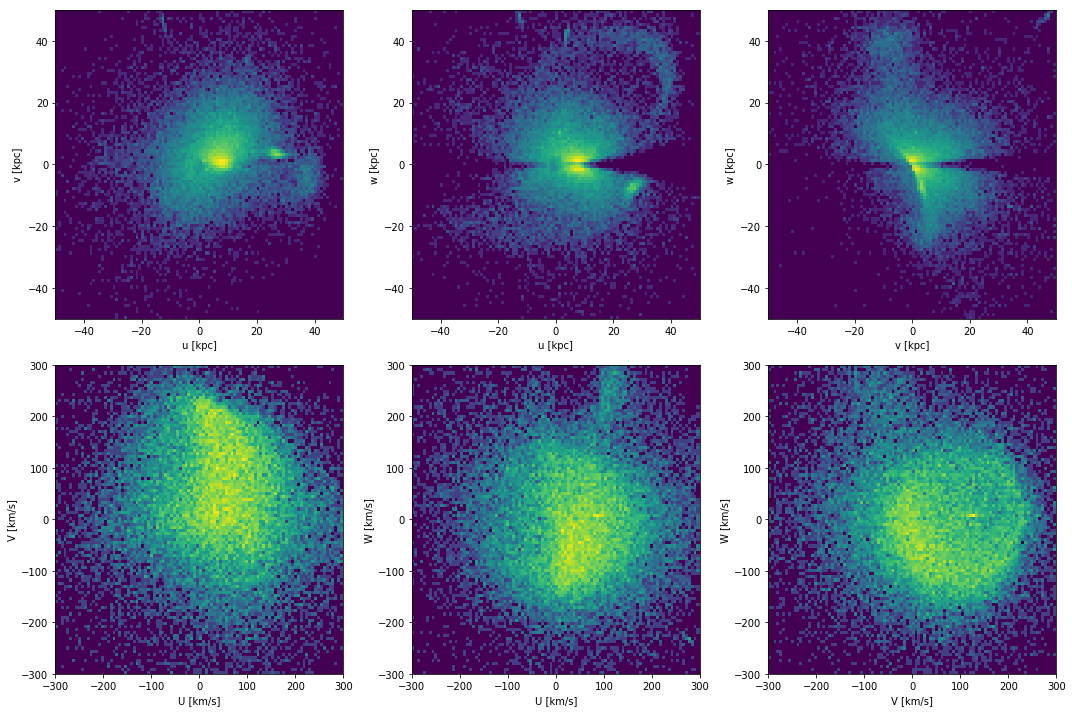

In [18]:
x = [cGal.u, cGal.u, cGal.v, cGal.U, cGal.U, cGal.V]
y = [cGal.v, cGal.w, cGal.w, cGal.V, cGal.W, cGal.W]
limPos = [-50, 50]
limVel = [-300, 300]
ranges = [limPos, limPos, limPos, limVel, limVel, limVel]
xlabel = ['u [kpc]', 'u [kpc]', 'v [kpc]', 'U [km/s]', 'U [km/s]', 'V [km/s]']
ylabel = ['v [kpc]', 'w [kpc]', 'w [kpc]', 'V [km/s]', 'W [km/s]', 'W [km/s]']
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()
for i, a in enumerate(ax):
    H, xe, ye = np.histogram2d(x[i], y[i], 
                           bins=100, range=[ranges[i], ranges[i]])
    m = a.pcolormesh(xe, ye, H.T+1, norm=mpl.colors.LogNorm())
    m.set_rasterized(True)
    a.set_xlabel(xlabel[i])
    a.set_ylabel(ylabel[i])
    #a.colorbar()
plt.tight_layout()
fig.savefig('RRlyraeUVW.pdf') 

In [58]:
treedata = pd.DataFrame(data={'u':cGal.u/(1.*u.kpc), 
                              'v':cGal.v/(1.*u.kpc), 
                              'w':cGal.w/(1.*u.kpc),
                              'U':cGal.U/(5.*u.km/u.s),
                              'V':cGal.V/(5.*u.km/u.s), 
                              'W':cGal.W/(5.*u.km/u.s)})

In [59]:
tree = kdtree(treedata)

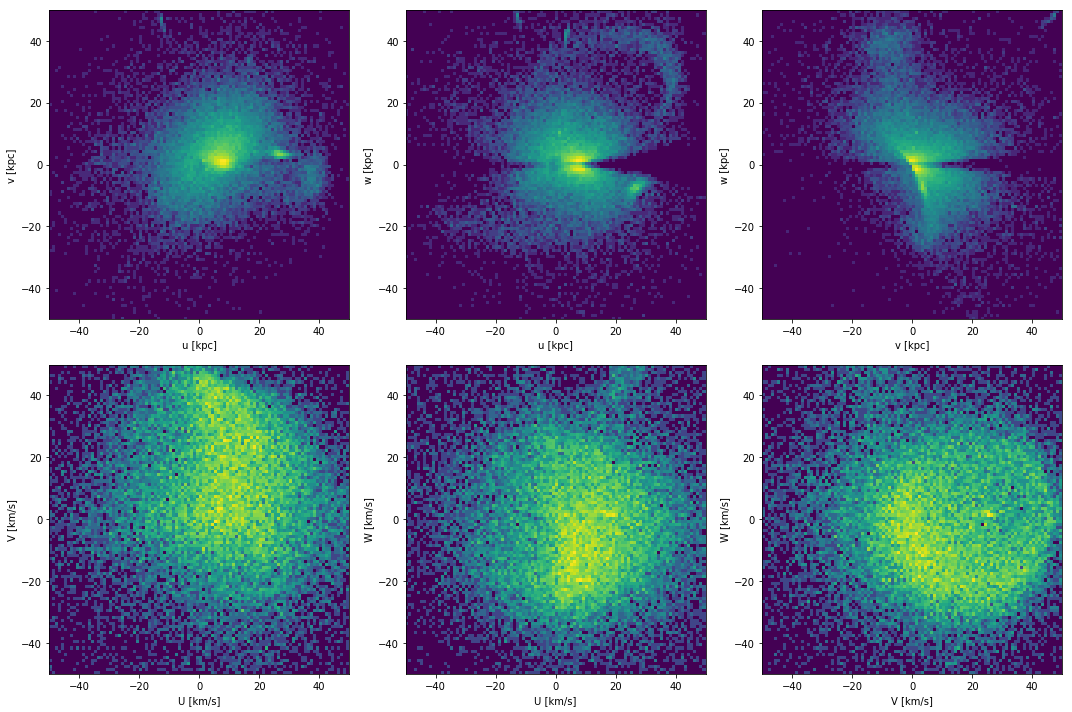

In [61]:
x = [treedata.u, treedata.u, treedata.v, treedata.U, treedata.U, treedata.V]
y = [treedata.v, treedata.w, treedata.w, treedata.V, treedata.W, treedata.W]
limPos = [-50, 50]
limVel = [-50, 50]
ranges = [limPos, limPos, limPos, limVel, limVel, limVel]
xlabel = ['u [kpc]', 'u [kpc]', 'v [kpc]', 'U [km/s]', 'U [km/s]', 'V [km/s]']
ylabel = ['v [kpc]', 'w [kpc]', 'w [kpc]', 'V [km/s]', 'W [km/s]', 'W [km/s]']
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.flatten()
for i, a in enumerate(ax):
    H, xe, ye = np.histogram2d(x[i], y[i], 
                           bins=100, range=[ranges[i], ranges[i]])
    m = a.pcolormesh(xe, ye, H.T+1, norm=mpl.colors.LogNorm())
    m.set_rasterized(True)
    a.set_xlabel(xlabel[i])
    a.set_ylabel(ylabel[i])
    #a.colorbar()
plt.tight_layout()
fig.savefig('RRlyraeUVW.pdf') 

In [89]:
radius = 1.0
(ind, dist) = tree.query_radius(treedata, radius, 
                                count_only = False, 
                                return_distance = True,
                               sort_results = True)

In [90]:
maxMembers= 10000
minMembers = 2
clumpIndices = []
for i in ind:
    if (len(i)>=minMembers) & (len(i)<=maxMembers): 
        clumpIndices.append(i)
print(len(clumpIndices))

211


In [91]:
all = np.concatenate(clumpIndices)

In [92]:
forsure

masked_BaseColumn(data = [False  True False ..., False False False],
                  mask = False,
            fill_value = 1.0)

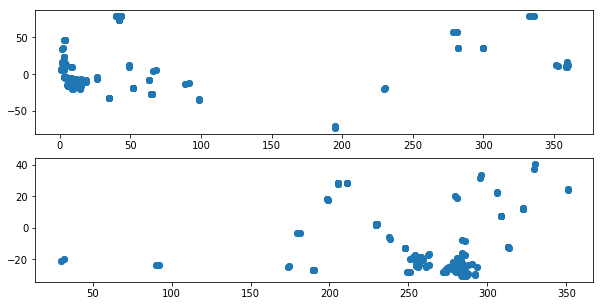

In [93]:
fig, ax = plt.subplots(2, figsize=(10, 5))
ax[0].scatter(cGalactic[all].l, cGalactic[all].b)
ax[1].scatter(data[forsure][all]['ra_1a'], data[forsure][all]['dec_1a'])

In [94]:
def sameIndices(cI, CI_previous):
    for c in CI_previous:
        same = np.sum(np.isin(cI, c))
        if same == len(cI): 
            return 'old'
    return 'new'

In [101]:
try:
    clumpTable = pd.read_pickle('clumpTablePairsPanstarrs')
    displaySkyPlot=True
except FileNotFoundError:
    displaySkyPlot=False
    clumpTable = pd.DataFrame(columns = ('pairNumber', 'index', 'nRRlyrae', 'ra', 'dec', 'pmra', 'pmdec', 'distance', 'width', 'angularSizeR'))
    ti = 0
    for j in range(len(clumpIndices)):
        if j % 100 == 0: print(j)
        cI = clumpIndices[j]
        #check that it isn't the same as a previous clump
        same = sameIndices(cI, clumpIndices[0:j])
        #print(same)
        if same == 'old':
            continue 
        else:
            tree_c = treedata.iloc[cI]
            width = np.sqrt((tree_c.u - np.mean(tree_c.u))**2 + 
                            (tree_c.v - np.mean(tree_c.v))**2 + 
                            (tree_c.w - np.mean(tree_c.w))**2) #kpc
            dnow = data[forsure][cI]
            for i, da in enumerate(dnow):
                clumpTable.loc[ti] = [j, cI[i], len(cI), da['ra_1a'], da['dec_1a'], da['pmra'], da['pmdec'], 
                                  distance[forsure][cI[i]], np.max(width), np.max(width*u.kpc/cGalactic[cI].distance*180./np.pi)]
                ti += 1
    clumpTable.to_pickle('clumpTablePairsPanstarrs')

0
100
200


In [114]:
cClumps = coord.SkyCoord(ra=clumpTable.ra.values*u.deg, 
                   dec=clumpTable.dec.values*u.deg, 
                   pm_ra_cosdec=clumpTable.pmra.values*u.mas/u.yr,
                   pm_dec=clumpTable.pmdec.values*u.mas/u.yr,
                   distance = clumpTable.distance.values*u.kpc, 
                   radial_velocity=0.*u.km/u.s)
cCorrectClumps = reflex_correct(cClumps)
cGalClumps = cCorrectClumps.transform_to(coord.Galactic)
cGalacticClumps = cCorrectClumps.transform_to(coord.Galactic)
cGalClumps.set_representation_cls('cartesian')

In [121]:
locgalaxiesfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/NearbyGalaxies.dat'
locgaldata = Table.read(locgalaxiesfile, format='ascii')
gcfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/Harris-globclust.fits'
gcdata = Table.read(gcfile, format='fits')
locGalc = coord.SkyCoord(ra=locgaldata['RA'], dec=locgaldata['Dec'], unit=(u.hourangle, u.deg))
gcc     = coord.SkyCoord(ra=gcdata['ra'],     dec=gcdata['dec'], unit=(u.hourangle, u.deg))

locGalcGal = locGalc.transform_to(coord.Galactic)
gccGal = gcc.transform_to(coord.Galactic)

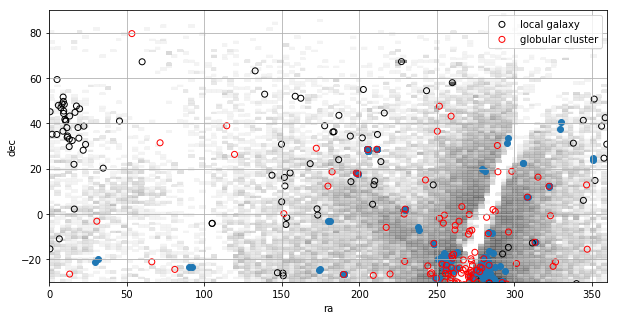

In [124]:
figSky, axSky = plt.subplots(figsize=(10, 5))
H, xe, ye = np.histogram2d(data[forsure]['ra_1a'], data[forsure]['dec_1a'], 
                           bins=100)

axSky.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
#mwsts.plot_stream_compilation(axSky,plot_colorbar=True,scat_kwargs=dict(vmin=0.,vmax=80.,cmap=cmapp, alpha=0.3),
                                  #use_shortnames=False, cb_kwargs=dict(label='Heliocentric Distance (kpc)'), 
                                  #verbose=False, cootype='gal')
axSky.scatter(clumpTable.ra.values, clumpTable.dec.values) #, s=3*clumpTable.nRRlyrae.values)

axSky.scatter(locGalc.ra, locGalc.dec, facecolor='none', edgecolor='black', label='local galaxy')
axSky.scatter(gcc.ra, gcc.dec, facecolor='none', edgecolor='red', label='globular cluster')

#axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies')
#axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters')
axSky.set_xlabel('ra')
axSky.set_ylabel('dec')
axSky.set_xlim(0, 360)
axSky.set_ylim(-30, 90)
axSky.legend(fontsize=15)
axSky.set_rasterized(True)
plt.grid()
plt.legend()
figSky.savefig('allsky_pairs_panstarrs_radec.pdf', rasterized=True, dpi=400)
#plt.close(figSky)

In [130]:
clumpTable[(np.abs(clumpTable.ra - 175) < 20) & (np.abs(clumpTable.dec + 25) < 20)]

,pairNumber,index,nRRlyrae,ra,dec,pmra,pmdec,distance,width,angularSizeR
535,174,27418,2,174.549962,-24.131323,-0.945345,-1.317240,20.989424,0.170893,0.46864664790310073
536,174,27419,2,173.763192,-24.671231,-0.985274,-1.329680,20.892969,0.170893,0.46864664790310073
537,176,27464,2,189.908981,-26.710260,-2.897178,1.807958,10.423178,0.270899,1.4891219481447124
538,176,27465,2,189.822291,-26.719407,-2.733931,1.642190,10.964781,0.270899,1.4891219481447124
539,177,27465,3,189.822291,-26.719407,-2.733931,1.642190,10.964781,0.312848,1.634768982847441
540,177,27468,3,189.876115,-26.775822,-2.778767,1.706964,10.568179,0.312848,1.634768982847441
541,177,27464,3,189.908981,-26.710260,-2.897178,1.807958,10.423178,0.312848,1.634768982847441
542,178,27466,2,189.864774,-26.684430,-2.933872,1.781533,10.715186,0.170330,0.9406167660479117
543,178,27476,2,190.001310,-26.699872,-3.017757,1.908670,10.375279,0.170330,0.9406167660479117


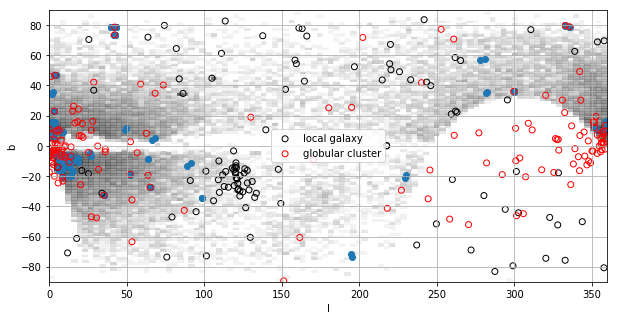

In [126]:
figSky, axSky = plt.subplots(figsize=(10, 5))
H, xe, ye = np.histogram2d(cGalactic.l, cGalactic.b, 
                           bins=100)

axSky.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
#mwsts.plot_stream_compilation(axSky,plot_colorbar=True,scat_kwargs=dict(vmin=0.,vmax=80.,cmap=cmapp, alpha=0.3),
                                  #use_shortnames=False, cb_kwargs=dict(label='Heliocentric Distance (kpc)'), 
                                  #verbose=False, cootype='gal')
axSky.scatter(cGalacticClumps.l.value, cGalacticClumps.b.value) #, s=3*clumpTable.nRRlyrae.values)

axSky.scatter(locGalcGal.l, locGalcGal.b, facecolor='none', edgecolor='black', label='local galaxy')
axSky.scatter(gccGal.l, gccGal.b, facecolor='none', edgecolor='red', label='globular cluster')


#axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies')
#axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters')
axSky.set_xlabel('l')
axSky.set_ylabel('b')
axSky.set_xlim(0, 360)
axSky.set_ylim(-90, 90)
axSky.legend(fontsize=15)
axSky.set_rasterized(True)
plt.grid()
plt.legend()
figSky.savefig('allsky_pairs_panstarrs_radec.pdf', rasterized=True, dpi=400)
#plt.close(figSky)

In [136]:
cOrphanClumps = cClumps.transform_to(gc.Orphan)

(-5, 5)

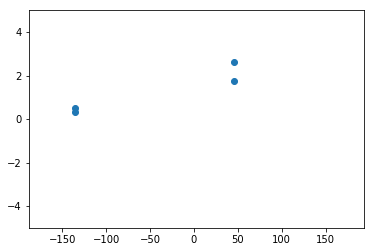

In [140]:
plt.scatter(cOrphanClumps.phi1.wrap_at(180*u.deg), cOrphanClumps.phi2)
plt.ylim(-5, 5)

(-5, 5)

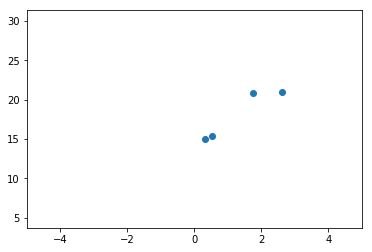

In [142]:
plt.scatter(cOrphanClumps.phi2, cOrphanClumps.distance)
plt.xlim(-5, 5)

In [135]:
clumpTable.head(5)

,pairNumber,index,nRRlyrae,ra,dec,pmra,pmdec,distance,width,angularSizeR
0,0,1451,2,198.162842,18.095075,-0.157787,-1.170475,18.113417,0.126354,0.39967762202980744
1,0,1459,2,198.189107,18.150530,-0.151262,-1.178316,18.365381,0.126354,0.39967762202980744
2,2,1481,2,199.171772,17.636241,-0.329823,-1.341040,16.672476,0.047978,0.16487874993657
3,2,1482,2,198.997235,17.741016,-0.354902,-1.349911,16.749428,0.047978,0.16487874993657
4,4,2126,6,205.467934,28.101194,-0.308181,-2.503311,10.423178,0.127356,0.7098108960251278
